In [46]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
# Функция для отрисовки маршрута
def graf(child, const):
    x_c = []
    y_c = []
    for i in range(len(child)):
        x_c.append(child[i][0])
        y_c.append(child[i][1])
    x_c.append(child[0][0])
    y_c.append(child[0][1])
    fig, ax = plt.subplots(figsize = (6,5))
    ax.scatter(x_c, y_c)
    if const == 1:
        plt.plot(x_c, y_c)

In [48]:
# Класс City создаем города, их координаты (x, y) 
# + считаем расстояние между городами по теореме Пифагора
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [49]:
# Класс Fitness (пригодность - обратная к расстоянию маршрута). 
# Минимизация длины маршрута + учет того, что заканчиваем в той же точке, 
# что и начинали
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [50]:
# Создание популяции

# Создание особи
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

# Создание нужного количества особей
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [51]:
# Упорядочиваем список маршрутов по пригодности (чем меньше длина - тем лучше)
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [52]:
# Выбор родителей
# Первый этап: используем упорядоченный список маршрутов, 
# настраиваем колесо рулетки, вычисляем относительный вес каждой особи,
# сравниваем случайно выпавшее число с весами
# + используем элитарность (переход лучших особй в следующее поколение)
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

# Создаем пул для спаривания, выбирая нажных нам обобей
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [53]:
# Скрещивание
# Сложность в том, что у каждой особи (ребенка) 
# должен присутствавать каждый город и при том только идин раз. 
# Скрещивание быдет происходить следующим образом: случайным образом выбираем 
# кусок от первого родителя, а все остальное заполняем генами второго родителя, 
# в том же порядке, что и у него исключая повторения (то, что мы взяли у первого
# родителя), таким образом удастся извежать дублирования городов
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [54]:
# Создание новой популяции из детей и лучших особей из первого поколения 
# (те, которые прошли по "элитарности")
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [55]:
# Мутация 
# Нужна для того, чтобы решение не застряло в какой-то точке
# Вводим новые маршруты, для исследования новых возможностей 
# Из-за того, что все города должны присутствавать в каждой особи и 
# по одному разу, мы воспльльзуемся перестановкой, то есть с некой вероятностью 
# два города поменяются местами в особи
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

# Используем функцию мутации на всем поколении
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [56]:
# Собираем все функции вместе
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

# Готовый генетический алгоритм, осталось только задать изначальную популяцию
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [57]:
# Создаем список городов
points = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (3, 9), (4, 9), (5, 9), (8, 8), (9, 9), 
          (9, 8), (8, 7), (8, 6), (8, 5), (7, 5), (7, 4), (7, 3), (7, 2), (6, 2), (5, 2), (4, 2), (3, 2), (3, 1), (2, 1), (5, 5)]

cityList = []
for i in range(len(points)):
    cityList.append(City(x = int(points[i][0]), y = int(points[i][1])))

In [58]:
# Запускаем генетический алгоритм
best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=2000)

# Количество особей (popSize) = 100 
# Количество элитных особей (eliteSize) = 20 (они сразу попадут в следующее поколение) 
# Процент мутаций (mutationRate) = 1% 
# Количество поколений (generations) = 500

Initial distance: 129.2909554843764
Final distance: 37.291267864660334


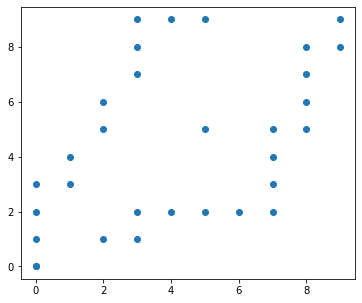

In [59]:
const = 0
graf(points, const)
plt.show()

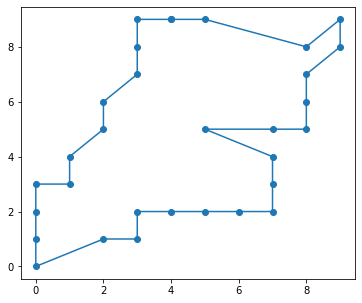

In [60]:
const = 1
best_route_new = [(d.x, d.y) for d in best_route]
graf(best_route_new, const)
plt.show()


cityList = []

for i in range(0,25):
    cityList.append(City(x = int(random.random() * 200), y = int(random.random() * 200)))
cityList  